In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import collections

In [2]:
DATA_PATH = './data/'
with open(DATA_PATH+'importance_scores_group_prediction.pkl','rb') as f:
    scores_per_graph = pickle.load(f)

In [7]:
# DATA_PATH = './data/'
# with open(DATA_PATH+'scores_per_graph.pkl','rb') as f:
#     scores_per_graph = pickle.load(f)

In [3]:
len(scores_per_graph)

140

In [4]:
scl = scores_per_graph[0] # look at dataframe for first graph

In [5]:
scl

,cell_type,X,Y,cell_id,spot_id,campp_0,campp_1,campp_2,campp_3,campp_4,campp_5,campp_6,campp_7,campp_8,campp_9,campp_median,campp_mad
0,granulocytes,77.0,589.0,0,0,0.016950,0.350585,0.000000,0.116528,0.140501,0.017379,0.099837,0.129521,0.024781,0.007914,0.062309,0.076995
1,granulocytes,106.0,826.0,1,0,0.014687,0.075043,0.240120,0.269666,0.001379,0.047645,0.000000,0.006499,0.023416,0.148588,0.035531,0.082052
2,granulocytes,107.0,545.0,2,0,0.068091,0.000000,0.000000,0.030736,0.028675,0.017152,0.000000,0.099696,0.010412,0.000000,0.013782,0.025059
3,granulocytes,98.0,564.0,3,0,0.007142,0.281647,0.000000,0.060714,0.322154,0.054891,0.217566,0.138132,0.020155,0.000000,0.057803,0.103708
4,granulocytes,217.0,329.0,4,0,0.252162,0.901895,0.414942,0.469559,0.380645,0.344093,0.475564,0.249722,0.201604,0.044381,0.362369,0.155064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,undefined,1686.0,503.0,240084,0,0.110061,0.000000,0.020442,0.093610,0.008543,0.000000,0.257543,0.010750,0.000000,0.080056,0.015596,0.061774
1160,undefined,1868.0,553.0,240085,0,0.073889,0.000000,0.000000,0.104903,0.000000,0.042700,0.000000,0.002508,0.000000,0.061639,0.001254,0.033775
1161,tumor cells / immune cells,1310.0,135.0,246598,0,0.038855,0.000000,0.037085,0.113898,0.026791,0.000000,0.022953,0.051900,0.000000,0.000715,0.024872,0.024972
1162,immune cells / vasculature,1634.0,1242.0,248395,0,0.000000,0.000000,0.000000,0.081498,0.063708,0.007302,0.000000,0.001153,0.000000,0.070375,0.000576,0.029674


### Find kNN of each important cell and use them as neighborhoods

In [6]:
df = pd.read_csv(DATA_PATH+'CRC_master.csv')

In [7]:
cell_type_dict = {}
for i,cell_type in enumerate(df.ClusterName.unique()):
    cell_type_dict[cell_type] = i

In [8]:
spots = df['spots'].unique()

In [72]:
pt_data = pd.read_excel(DATA_PATH+'CRC_TMAs_patient_annotations.xlsx')

/home/joeleliason/anaconda3/envs/hactnet/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [80]:
spots_nbhds = []
total_nbhds = 0
nn = 10
threshold = 0.3
all_cell_types = df.ClusterName.unique().tolist()
patient_id = 0
for i,scl in enumerate(scores_per_graph):
    spot_id = scl.spot_id.unique()[0]
    spot_id = spots[spot_id]
    X = scl.loc[:,'X':'Y'].values
    knn = NearestNeighbors(n_neighbors=nn)
    knn.fit(X)
    important_cells = scl[(scl['campp_median'] >= threshold) & (scl['cell_type'] != 'dirt')]
    imp_cell_coord = important_cells.loc[:,'X':'Y'].values
    num_nbhds = imp_cell_coord.shape[0]
    total_nbhds += num_nbhds
    if num_nbhds == 0:
        spots_nbhds[spot_id] =[]
        continue
    knn_important = knn.kneighbors(imp_cell_coord, return_distance=False).tolist()
    nbhd_cell_types = []
    for cells in knn_important:
        nbhd_cell_types.append([cell_type for cell_type in scl.iloc[cells]['cell_type'].values.tolist()])
    counts = [collections.Counter(s) for s in nbhd_cell_types]
    spots_nbhds_df = pd.DataFrame(0, index=[i for i in range(num_nbhds)], columns=['patient_group','patient_id','spot_id','centroid_X','centroid_Y'] + all_cell_types)
    spots_nbhds_df.loc[:,all_cell_types[0]:all_cell_types[-1]] = np.array([[counter[ct] for ct in all_cell_types] for counter in counts])
    spots_nbhds_df.loc[:,'spot_id'] = spot_id
    if i % 4 == 0:
        patient_id += 1
    spots_nbhds_df.loc[:,'patient_id'] = patient_id
    cp = pt_data.loc[pt_data.loc[:,'Patient'] == patient_id,'Group'].values[0]
    assert(cp == 1 or cp == 2)
    spots_nbhds_df.loc[:,'patient_group'] = cp
    spots_nbhds_df.loc[:,'centroid_X':'centroid_Y'] = [scl.iloc[cells].loc[:,'X':'Y'].values.mean(axis=0) for cells in knn_important]
    # spots_nbhds[spot_id] = {
    #     'nbhd_cell_types': np.array([[counter[ct] for ct in all_cell_types] for counter in counts]),
    #     'nbhd_coords': imp_cell_coord
    # }
    spots_nbhds.append(spots_nbhds_df)
nbhds_df = pd.concat(spots_nbhds,ignore_index=True)

In [82]:
nbhds_df.patient_group.value_counts()

2    1652
1     859
Name: patient_group, dtype: int64

Roughly twice as many important neighborhoods for group 2 than in group 1

In [83]:
with open(DATA_PATH+'spots_nbhds_df.pkl','wb') as f:
    pickle.dump(nbhds_df,f)

In [84]:
nbhds_df.to_csv(DATA_PATH+'spots_nbhds_df.csv',index=False)

In [51]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X = nbhds_df.drop(['patient_id','spot_id','centroid_X','centroid_Y'],axis=1).values

X = StandardScaler().fit_transform(X)

# Compute DBSCAN
db = DBSCAN(eps=2.0, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [52]:
X

array([[ 0.74919509, -0.38964127, -0.40416676, ..., -0.04466779,
        -0.01996012, -0.03994412],
       [ 0.74919509, -0.38964127, -0.40416676, ..., -0.04466779,
        -0.01996012, -0.03994412],
       [ 0.74919509, -0.38964127,  0.56329056, ..., -0.04466779,
        -0.01996012, -0.03994412],
       ...,
       [-0.45904439,  0.57239338,  1.53074787, ..., -0.04466779,
        -0.01996012, -0.03994412],
       [ 0.14507535,  0.57239338,  0.56329056, ..., -0.04466779,
        -0.01996012, -0.03994412],
       [ 0.14507535,  0.57239338,  0.56329056, ..., -0.04466779,
        -0.01996012, -0.03994412]])

In [53]:
labels

array([ 0,  0, -1, ..., -1,  0,  3])

In [54]:
n_clusters_

8

In [55]:
n_noise_

831

In [56]:
len(labels)

2511

### HDBSCAN

In [57]:
import hdbscan

In [58]:
X = nbhds_df.drop(['patient_id','spot_id','centroid_X','centroid_Y'],axis=1).values
X = X / 10
X = StandardScaler().fit_transform(X)

In [59]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, gen_min_span_tree=True)
clusterer.fit(X)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=20)

In [60]:
max(clusterer.labels_)

11

In [61]:
np.unique(clusterer.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([1667,   36,   74,   74,   57,   63,   37,  110,   25,   30,   35,
          40,  263]))

<AxesSubplot:ylabel='$\\lambda$ value'>

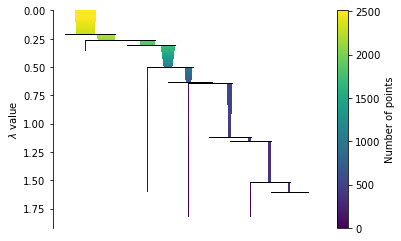

In [62]:
clusterer.condensed_tree_.plot()

/home/joeleliason/anaconda3/envs/hactnet/lib/python3.7/site-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


<AxesSubplot:ylabel='$\\lambda$ value'>

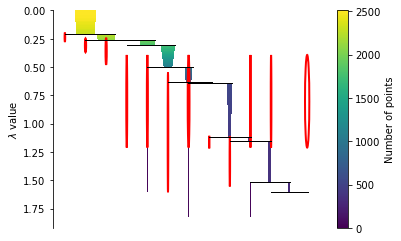

In [63]:
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))